# Glasgow coma motor scores of all adult patients
We would like to know the motor response of the Glasgow Coma Scale (GCS) for all adult (age >= 16) patients. A patient’s motor response GCS can range from 1 to 6, where a score of 1 means that the patient shows no movements, and a score of 6 means that the patient is able to obey commands. In the end, we would like to create a bar chart that shows the number of adult patients that have a certain motor response GCS.
### SQL query description
The diagram below visualizes how to get the Glasgow coma motor scores. First, we join the Patients and Admissions table based on the unique subject identifier, and we select each patient’s date of birth and each hospital admission time to be able to compute each patient’s age at the time of hospital admission. Next, for all adult patients (age >= 16), we select the values for the items that are called ‘Motor response’ and ‘GCS-Motor response’.
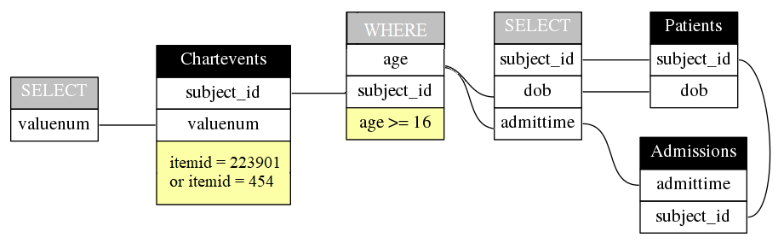
### Implementation of the above query
We are interested in item ids (chartevents.idemid) with values 454 (motor response) and 223901 (GCS motor response). The response can have different values (chartevents.valuenum) which we divide in 6 groups using width_bucket(). We then count the number of subjects in each of those 6 groups.

In [1]:
#imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
%matplotlib inline
# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'
# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [2]:
# First make sure we select the right itemids:
query ="""
SELECT d.itemid, d.label
FROM mimiciii.d_items d
WHERE d.label LIKE '%Motor Response%'
"""

query_output = pd.read_sql_query(query,con)
query_output

,itemid,label
0,454,Motor Response
1,223901,GCS - Motor Response


In [3]:
query ="""
WITH subjects_above16 AS(
    SELECT a.subject_id
    FROM mimiciii.admissions a
    INNER JOIN mimiciii.patients p
    ON a.subject_id = p.subject_id
    WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
    group by a.subject_id), coma_score_table AS
    (
    SELECT width_bucket(ce.valuenum, 1, 30, 30) AS bucket
    FROM mimiciii.chartevents ce
    INNER JOIN subjects_above16
    ON ce.subject_id = subjects_above16.subject_id
    WHERE ce.itemid IN (454, 223901)
    )
SELECT bucket as glasgow_coma_score, count(*)
FROM coma_score_table
GROUP BY bucket
ORDER BY bucket;
"""

query_output = pd.read_sql_query(query,con)

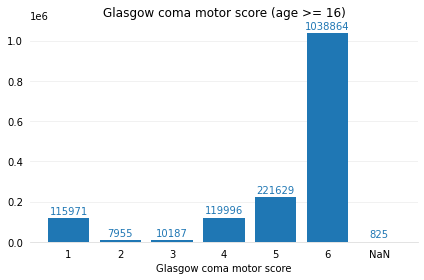

In [4]:
# Visualize:
fig, ax = plt.subplots()
bars = ax.bar(np.arange(7), query_output['count'], tick_label=['1', '2', '3', '4', '5', '6', 'NaN'])
plt.xlabel('Glasgow coma motor score')
plt.title('Glasgow coma motor score (age >= 16)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 20000,
        round(bar.get_height(), 1),
        horizontalalignment='center',
        color=bar_color,
        weight='normal')

plt.tight_layout()
fig.savefig('figures/glasgow_coma_motor_score.jpg', dpi=400)